#1) Introdução

Autoria: Jackson Corrêa

Linkedin: https://www.linkedin.com/in/jackson-corr%C3%AAa/
<br><br>
Este é um projeto de Ciência de Dados que tem como objetivo desenvolver um modelo de máquina preditiva para avaliar a probabilidade de um cliente, ou um conjunto de clientes, deixarem o banco, o que é conhecido como 'churn'.
<br>
<br>
O projeto consiste em duas macro-etapas:

* Análise exploratória dos dados, com extração de insights valiosos que podem ser utilizados pelo time de negócios;
* Pré processamento dos dados, com codificação de variáveis categóricas, balanceamento do dataframe e padronização dos dados;
* Modelagem de máquina preditiva, com análise de desempenho e otimização do algoritmo, de forma a obter um modelo final que possa ser disponibilizado para produção (deploy do modelo).
<br><br>

Foram escolhidos os seguintes classificadores para a modelagem da máquina preditiva:
* Regressão Logística
* Random Forest
* XGBoost
<br><br>

A métrica principal para avaliação do desempenho dos modelos é o Recall (Revocação), pois a pretensão é de que se reduza ao máximo a classificação de Falsos Negativos, ou seja, é preferível que um cliente que não tenha a pretensão de deixar o banco, seja classificado como 'churn', do que um cliente iminente a deixar o banco seja classificado como 'não churn'.
<br><br>


##1.1) Fonte de dados

Os dados utilizados neste projeto estão armazenadas em um dataset extraído da plataforma kaggle.

Link de acesso: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn

Combase nas correlações observadas entre as variáveis percebe-se que, muito prvavelmente o dataset é artificial, pois não há coerência com das relações com o comportamento de compra humano.
<br><br>

##1.2) Dicionário de dados

* RowNumber — corresponde ao número do registro (linha) e não tem efeito sobre a saída.

* CustomerId — contém valores aleatórios e não tem efeito sobre a saída do cliente do banco.

* Surname – é o sobrenome de um cliente e não tem impacto em sua decisão de deixar o banco.

* CreditScore — pontuação de creditScore definida pelo banco

* Geography — a localização de um cliente

* Gender – Gênero do cliente

* Age – Idade do cliente

* Tenure — refere-se ao número de anos em que o cliente possui conta do banco.

* Balance – Valor em conta

* NumOfProducts — número de produtos que um cliente comprou através do banco.

* HasCrCard — indica se um cliente tem ou não um cartão de crédito<br>
  0 = Não possui cartão<br>
  1 = Possui cartão

* IsActiveMember — indica se um cliente é classificado como 'ativo' ou 'não ativo<br>
  0 = Não ativo<br>
  1 = Ativo

* EstimatedSalary – Salário estimado do cliente

* Exited — se o cliente saiu ou não do banco.<br>
  0 = não saiu (não churn)<br>
  1 = saiu (churn)

* Complain: indica se cliente tem reclamação ou não<br>
  0 = Não possui reclamação<br>
  1 = Possui reclamação

* Satisfaction Score – pontuação fornecida pelo cliente para a resolução da reclamação.

* Card Type — tipo de cartão retido pelo cliente.

* Point Earned — os pontos ganhos pelo cliente pelo uso do cartão de crédito.




##1.3) Importação das bibliotecas

In [ ]:
# importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix,make_scorer

from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder

#2) Análise exploratória

##2.1) Visualizando os dados

In [ ]:
# Importando o dataset
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Bank Customer Churn/Customer-Churn-Records.csv',encoding='utf-8',sep=',')

In [ ]:
# Criando cópia do dataset
df=data.copy()

In [ ]:
# Visualizando o dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [ ]:
# dropando variáveis que não possuem nenhum potencial preditivo
df=df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [ ]:
# Sumarização do dataset - variáveis numéricas
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


In [ ]:
# Sumarização do dataset - variáveis categóricas
df.select_dtypes('object').describe()

,Geography,Gender,Card Type
count,10000,10000,10000
unique,3,2,4
top,France,Male,DIAMOND
freq,5014,5457,2507


In [ ]:
# Informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Geography           10000 non-null  object 
 2   Gender              10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Exited              10000 non-null  int64  
 11  Complain            10000 non-null  int64  
 12  Satisfaction Score  10000 non-null  int64  
 13  Card Type           10000 non-null  object 
 14  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

In [ ]:
# Valores faltantes por variável no dataset
df.isnull().sum()

CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [ ]:
# Valores únicos por variável
df.nunique()

CreditScore            460
Geography                3
Gender                   2
Age                     70
Tenure                  11
Balance               6382
NumOfProducts            4
HasCrCard                2
IsActiveMember           2
EstimatedSalary       9999
Exited                   2
Complain                 2
Satisfaction Score       5
Card Type                4
Point Earned           785
dtype: int64

In [ ]:
# Valores duplicados por variável
df.duplicated().sum()

0

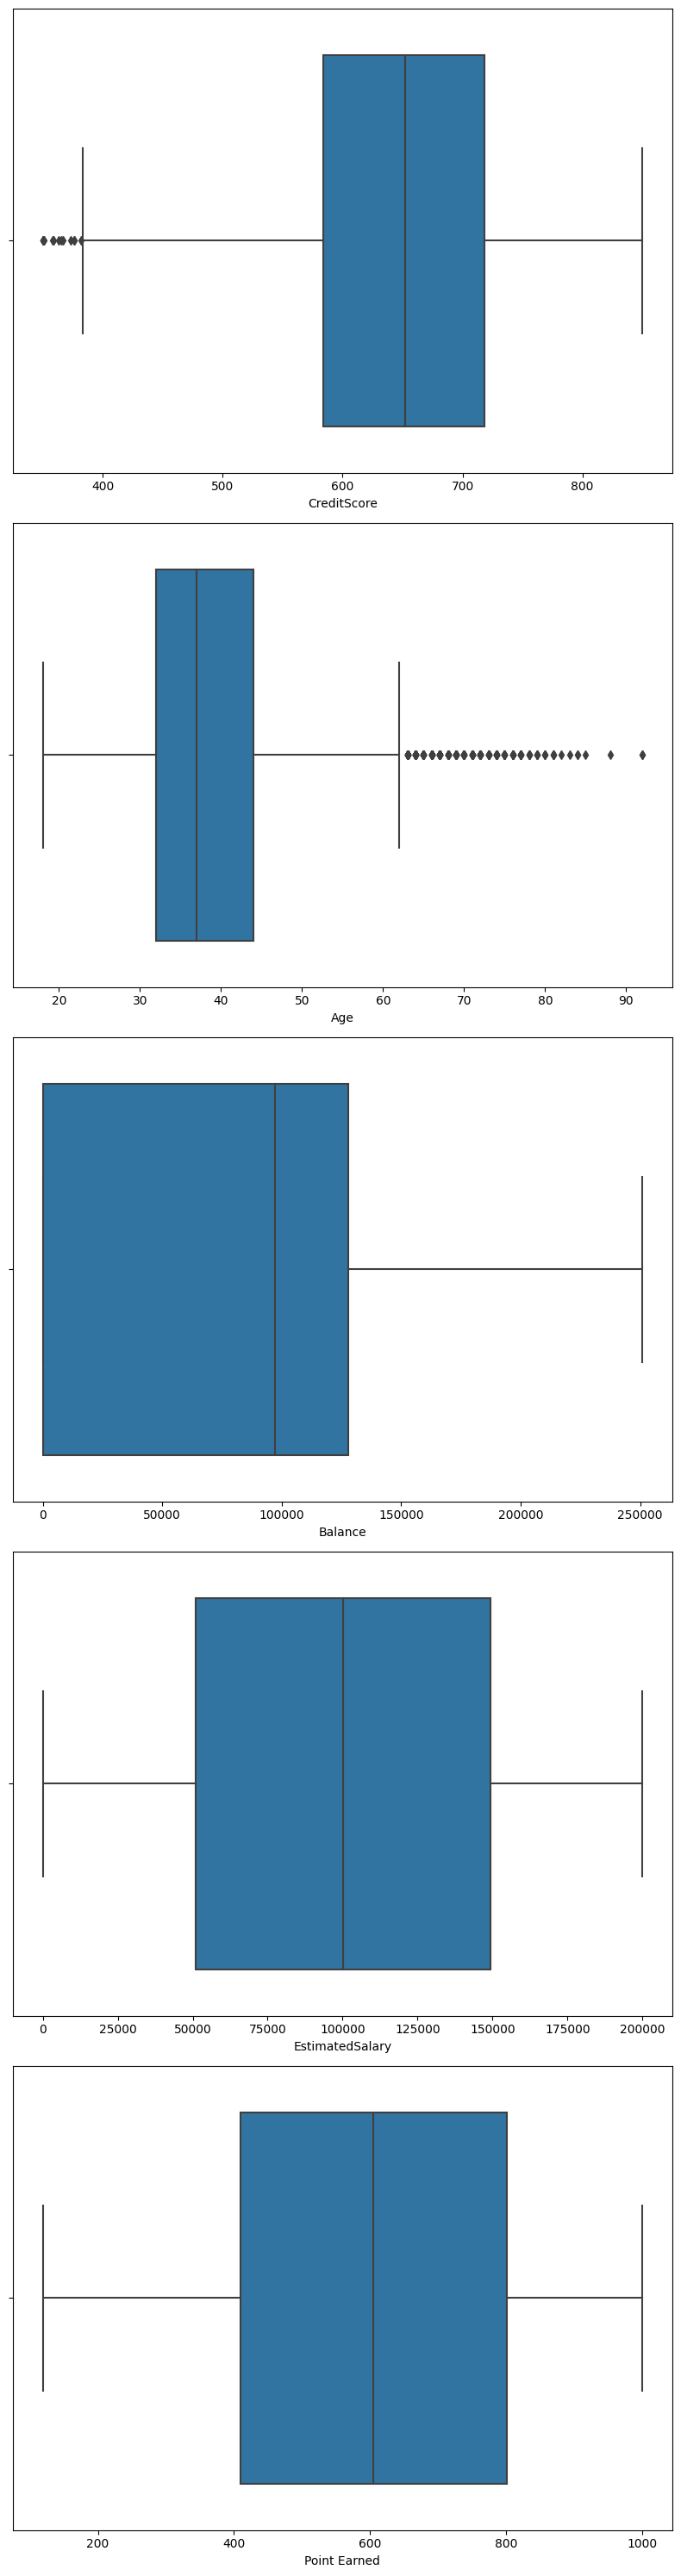

In [ ]:
# Visualizando os outliers das variáveis numéricas
variaveis=['CreditScore','Age','Balance','EstimatedSalary','Point Earned']

fig, axs = plt.subplots(nrows=len(variaveis), figsize=(8, 6 * len(variaveis)))  # Cria os subplots

for i, variavel in enumerate(variaveis):
  print('\n\n')
  sns.boxplot(x=df[variavel], ax=axs[i])  # Cria o boxplot para cada variável

plt.tight_layout()  # Ajusta o espaçamento entre os subplots
plt.show()  # Exibe o gráfico

As variáveis 'Age' e 'Credit Score' possuem outlers, mas que, aparetemente, não afetaram a distribuição, além de também não pareceremerros de digitação.
<br><br>

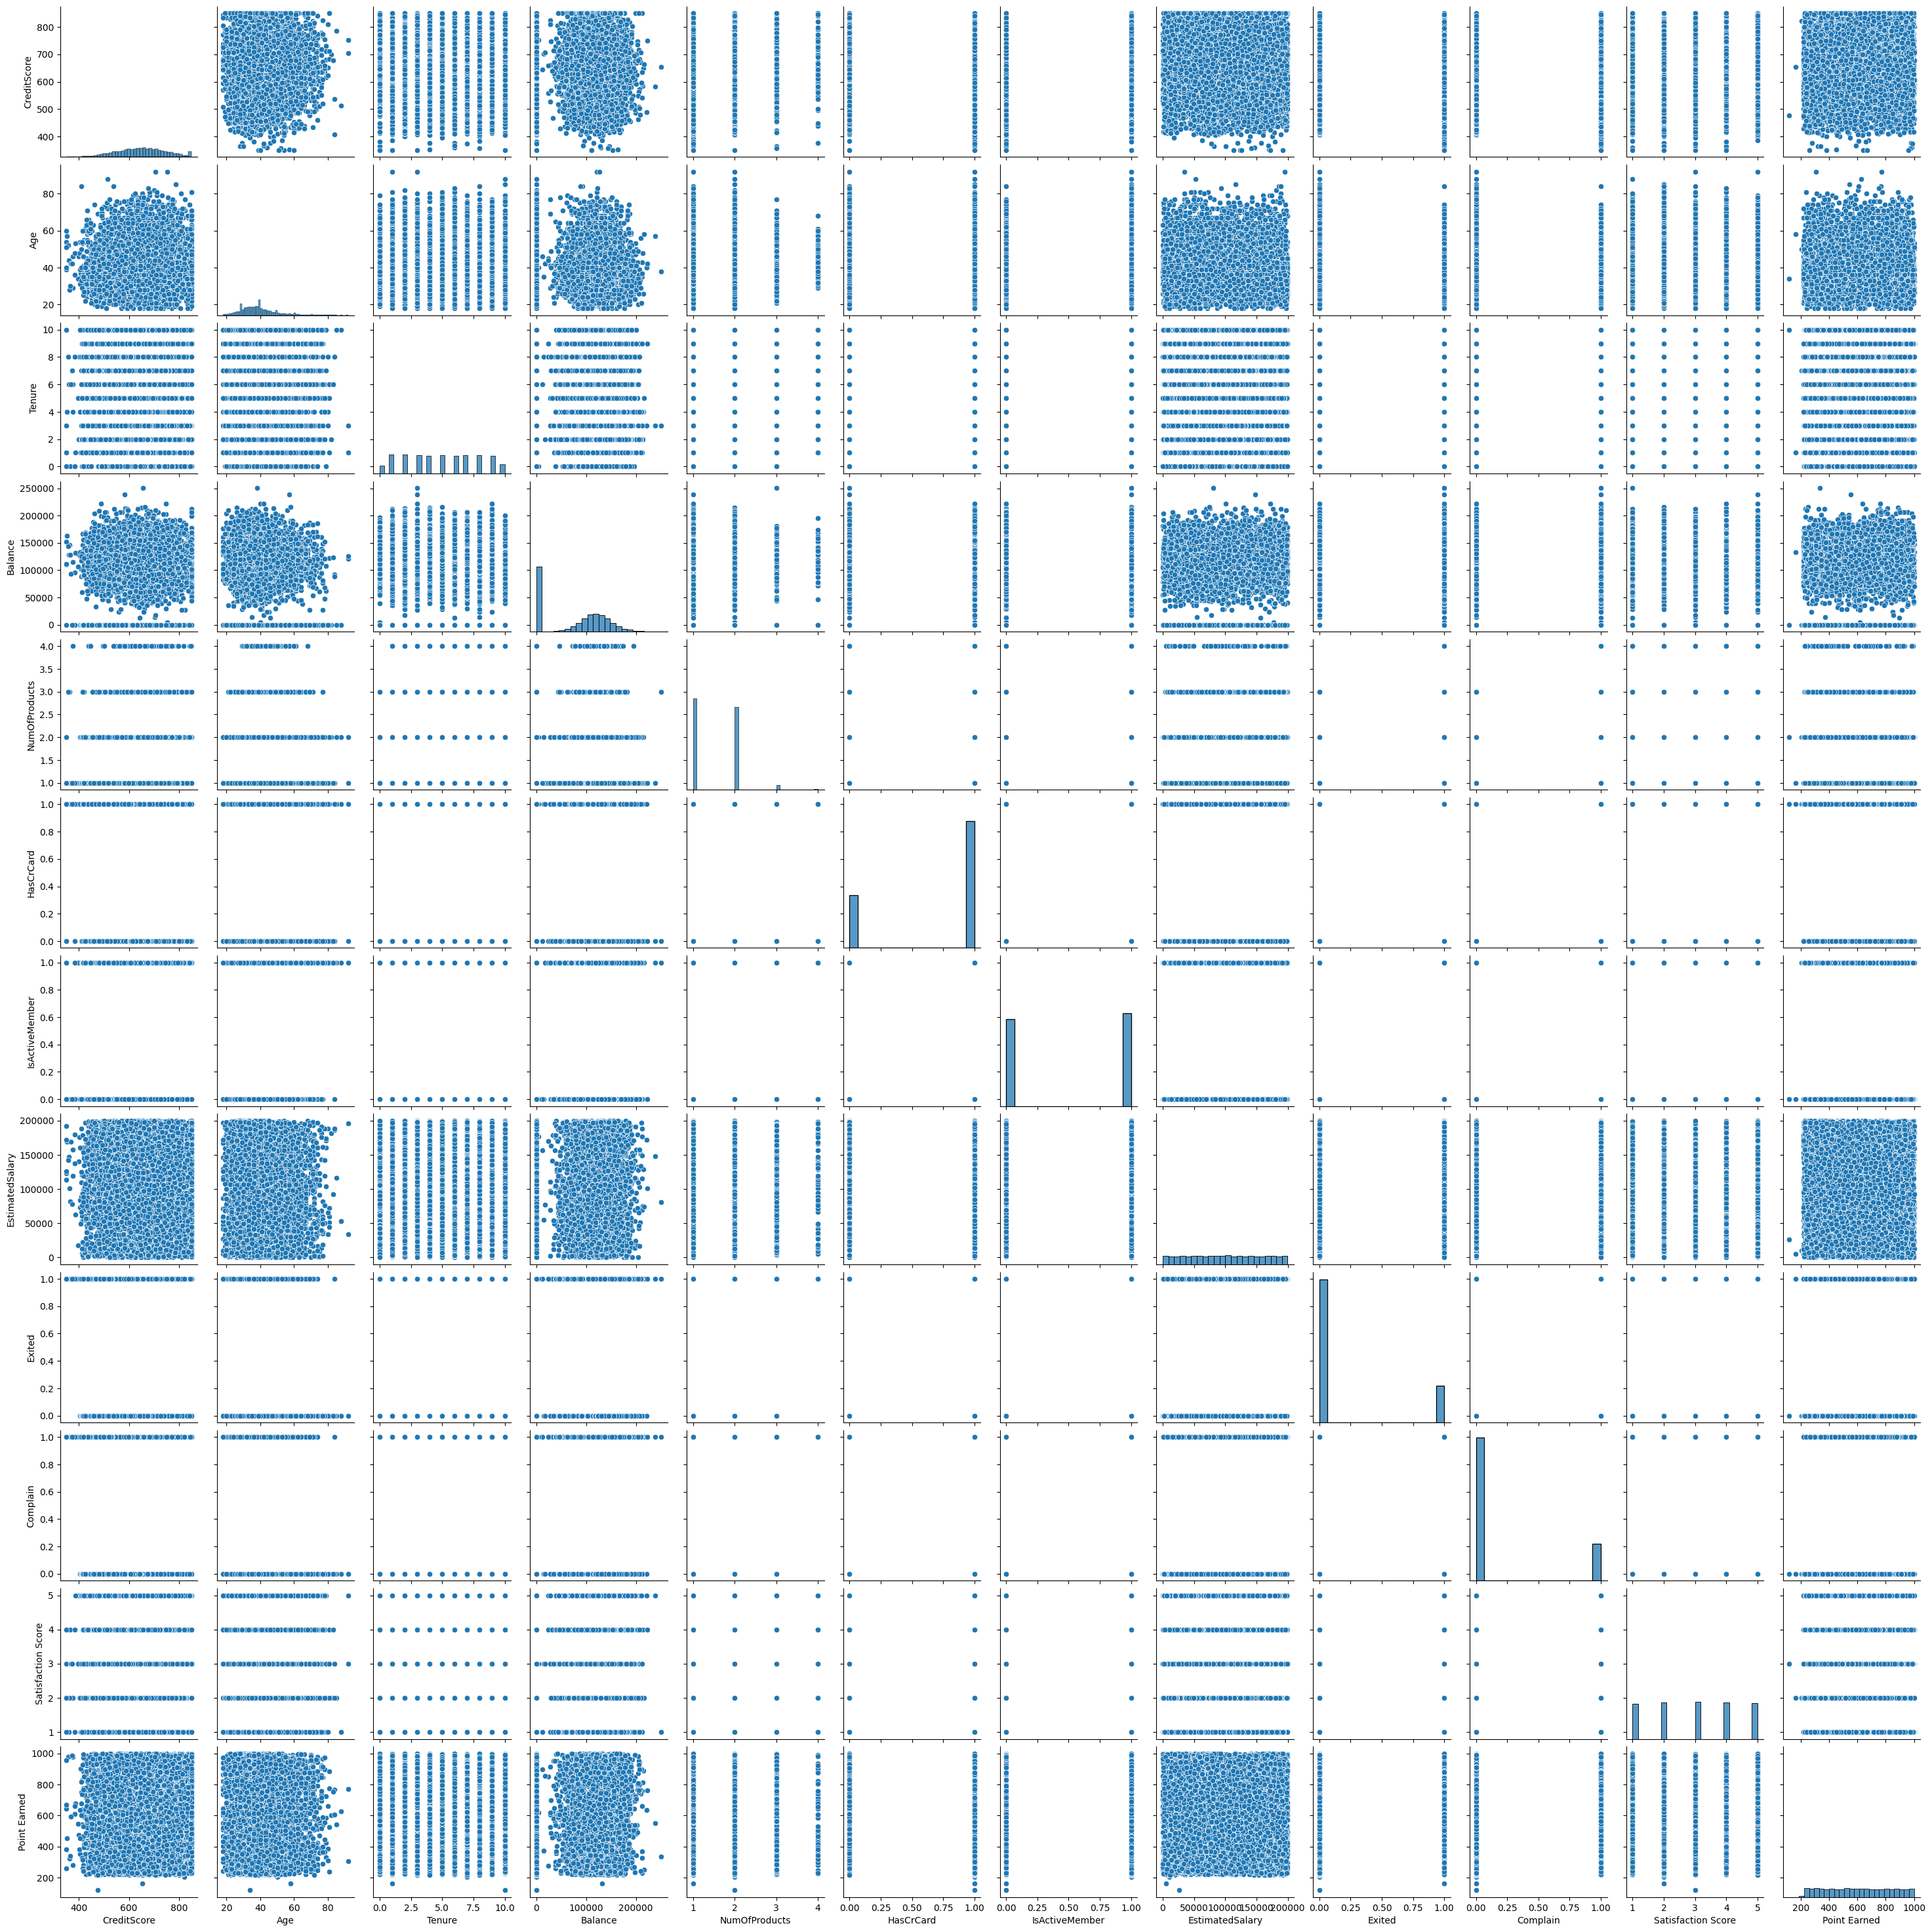

In [ ]:
# Visualizando a distribuição das relações etre variáveis
ax=sns.pairplot(df)

Não há relações explicitamente lineares.
<br><br>

##2.2) Insights



Insights extraídos da relação entre as variáveis e a variável alvo, com o intuito de direcionar a tomada de decisão na redução do 'churn'. Serão analisadas somente as relações para instâncias classificadas como 'churn' , pois é mais importante entender porque um cliente deixou o banco do que por que permaneceu.
<br><br>

In [ ]:
# Criando um dataframe auxiliar
churn=df[df['Exited']==1]

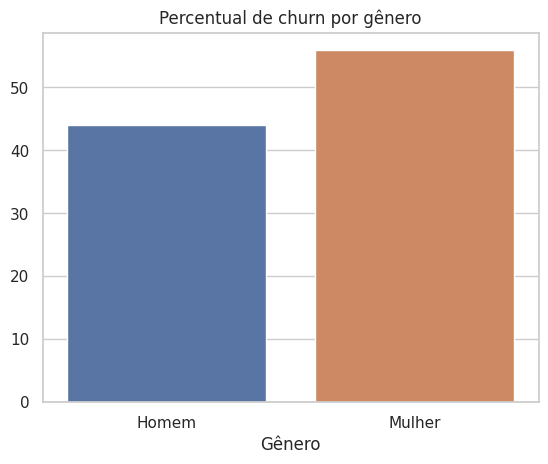

In [ ]:
# Percentual de ocorrência de churn por gênero
m=round(100*churn.loc[churn['Gender']=='Male','Gender'].count()/churn['Gender'].count(),1)
f=round(100*churn.loc[churn['Gender']=='Female','Gender'].count()/churn['Gender'].count(),1)

sns.set(style="whitegrid", color_codes=True)
ax=sns.barplot(data=churn,x=['Homem','Mulher'],y=[m,f])
ax.set_title('Percentual de churn por gênero')
ax.set_xlabel('Gênero')
_=plt.show

In [ ]:
# Percentual de ocorrência de churn por idade
churn.describe()['Age']

count    2038.000000
mean       44.835623
std         9.759754
min        18.000000
25%        38.000000
50%        45.000000
75%        51.000000
max        84.000000
Name: Age, dtype: float64

75% das ocorrências de churn são com pessoas de até 51 anos, o que pode indicar uma faixa limite de idade para investimento em prevenção.
<br><br>

In [ ]:
# Ocorrência de churn por tempo de conta no banco
churn.describe()['Tenure']

count    2038.000000
mean        4.934740
std         2.936768
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Tenure, dtype: float64

Metade das ocorrências de churn são com pessoas que possuem até 5 anos de conta.

75% das ocorrências são de pessoas com até 8 anos de conta.
<br><br>

In [ ]:
# Percentual de ocorrência de churn por tempo de conta no banco
anos=churn.groupby('Tenure').size().sort_values(ascending=False).index
percent=round(100*churn.groupby('Tenure').size().sort_values(ascending=False)/churn['Tenure'].count(),1).values

pd.DataFrame({'Anos de conta':anos,'Perc. churn':percent})

,Anos de conta,Perc. churn
0,1,11.4
1,9,10.5
2,3,10.5
3,5,10.3
4,4,10.0
5,2,9.9
6,8,9.7
7,6,9.6
8,7,8.7
9,10,5.0


Em primeiro lugar nas ocorrências de churn estão pessoas com 1 ano de conta.

Curiosamente, em segundo lugar, estão pessoas com 9 anos de tempo de conta e, em último, pessoas que não completaram o primeiro ano de conta.
<br><br>

In [ ]:
# Investigando as características das pessoas com mais de 9 anos de conta
churn[churn['Tenure']>=9].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.0,315.000000,315.000000,315.000000
mean,654.146032,44.888889,9.320635,93403.123111,1.501587,0.736508,0.314286,104996.271683,1.0,0.996825,3.022222,598.104762
std,103.321206,9.641853,0.467463,57706.085586,0.853522,0.441228,0.464969,57838.864480,0.0,0.056344,1.383299,225.606878
min,350.000000,19.000000,9.000000,0.000000,1.000000,0.000000,0.000000,123.070000,1.0,0.000000,1.000000,226.000000
25%,580.500000,39.000000,9.000000,64855.110000,1.000000,0.000000,0.000000,56043.600000,1.0,1.000000,2.000000,402.000000
50%,652.000000,45.000000,9.000000,111973.970000,1.000000,1.000000,0.000000,108761.050000,1.0,1.000000,3.000000,597.000000
75%,735.000000,51.000000,10.000000,133018.905000,2.000000,1.000000,1.000000,154657.815000,1.0,1.000000,4.000000,777.000000
max,850.000000,71.000000,10.000000,222267.630000,4.000000,1.000000,1.000000,199808.100000,1.0,1.000000,5.000000,997.000000


50% das ocorrências de churn com contas com 9 anos ou mais possuem somente 1 produto do banco e estes mesmos 50% também não são membros ativos.

Uma alternativa para a redução de churn nesta categoria seria a oferta de novos produtos, aproximando mais o cliente do banco, reduzindo o churn nesta classe.
<br><br>

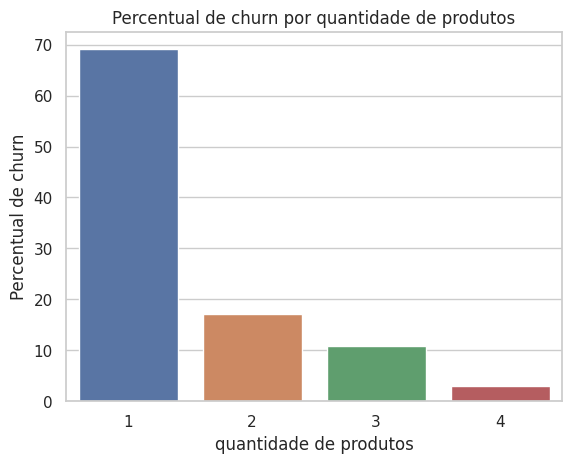

In [ ]:
# Relação entre Produtos x Churn

cont=churn['NumOfProducts'].value_counts()
percent=round(100*cont/churn['NumOfProducts'].count(),1)

ax=sns.barplot(x=cont.index,y=percent)
ax.set_ylabel('Percentual de churn')
ax.set_xlabel('quantidade de produtos')
ax.set_title('Percentual de churn por quantidade de produtos')
_=plt.show

Quase 70% das ocorrências de churn são de pessoas que possuiam somente um produto bancário.

Isto pode ser um indicativo para que sejam oferecidosovos produtos a estas pessoas.
<br><br>

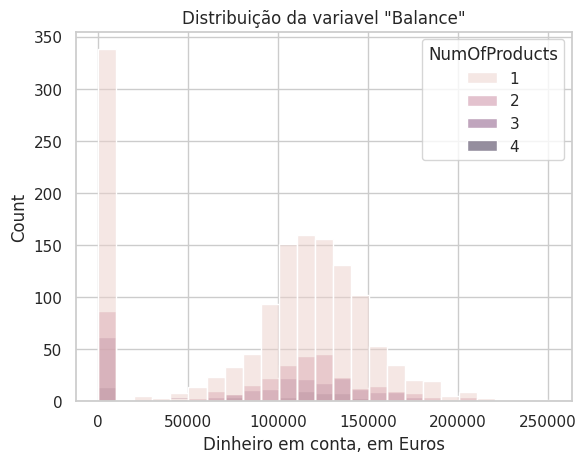

In [ ]:
# Percentual de ocorrência de churn em relação ao valor depositado em conta, discretizado pela quantidade de produtos bancários

# Verificando a distribuição
ax=sns.histplot(data=churn,x='Balance',hue='NumOfProducts',bins=25)
ax.set_title('Distribuição da variavel "Balance"')
ax.set_xlabel('Dinheiro em conta, em Euros')
_=plt.show

A maioria das ocorrências de churn está em contas sem nenhum valor depositado.
<br><br>

In [ ]:
# Investigando as caracrísticas de pessoas sem dinheiro em conta
churn[churn['Balance']==0].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,500.000000,500.000000,500.000000,500.0,500.000000,500.000000,500.000000,500.000000,500.0,500.0,500.000000,500.000000
mean,643.862000,44.934000,4.808000,0.0,1.504000,0.704000,0.360000,101782.089240,1.0,1.0,3.006000,581.324000
std,100.406344,9.683449,2.924421,0.0,0.816896,0.456948,0.480481,58029.831949,0.0,0.0,1.379046,224.767587
min,350.000000,18.000000,0.000000,0.0,1.000000,0.000000,0.000000,417.410000,1.0,1.0,1.000000,219.000000
25%,582.750000,38.000000,2.000000,0.0,1.000000,0.000000,0.000000,52701.152500,1.0,1.0,2.000000,390.750000
50%,645.000000,45.000000,5.000000,0.0,1.000000,1.000000,0.000000,100881.125000,1.0,1.0,3.000000,569.500000
75%,714.000000,52.000000,7.000000,0.0,2.000000,1.000000,1.000000,151778.442500,1.0,1.0,4.000000,758.250000
max,850.000000,73.000000,10.000000,0.0,4.000000,1.000000,1.000000,199290.680000,1.0,1.0,5.000000,998.000000


Das ocorrências de churn, a média de Pontos Ganhos (Point Earned) está em torno de 580 pontos, indicando que, mesmo que não haja dinheiro em conta, o cartão de crédito ainda é utilizado.

Isto pode indicar que oferecer programas de benefícios (como milhas, descontos em lojas parceiras, etc) para estes clientes pode reduzir a taxa de churn nesta classe.
<br><br>

In [ ]:
# Verificando o percentual de pessoas sem dinheiro em conta que ainda utilizam o cartão de crédito
perc= round(100* churn[(churn['Balance']==0) & (churn['HasCrCard']==1)].shape[0] / churn.loc[churn['Balance']==0,'Balance'].count(),1)
print(f'{perc}% dos cassos de churn, e que não tinham dinheiro em conta, ainda utilizavam o cartão de crédito.\n')

70.4% dos cassos de churn, e que não tinham dinheiro em conta, ainda utilizavam o cartão de crédito.



De acordo coma análise, melhores condições de crédito ou benefícios podem ser estudas para serem oferecidas para estas pessoas que, mesmo não tendo nenhum dinheiro em conta, ainda continuaram utilizando o cartão de crédito antes de deixarem o banco. Este ponto pode ser o sinal de alerta ao setor responsável.
<br><br>

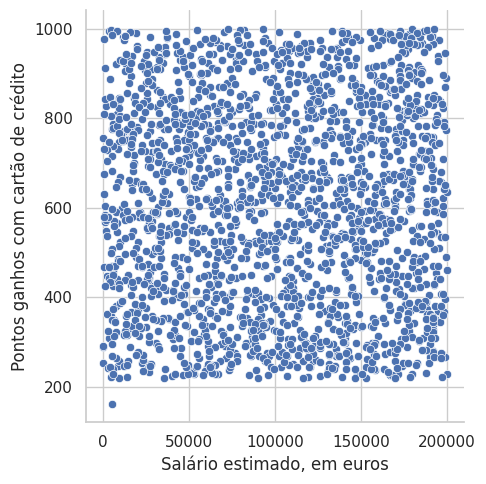

In [ ]:
# Verificando os agrupamentos que mais utilizam cartão de crédito em relação ao salário
ax=sns.relplot(data=churn,x='EstimatedSalary',y='Point Earned')
ax.set_titles('Salário estimado x Pontos ganhos co cartão de crédito')
ax.set_xlabels('Salário estimado, em euros')
ax.set_ylabels('Pontos ganhos com cartão de crédito')
_=plt.show

Não há relação perceptível da utilização do cartão de crédito com o salário estimado do cliente.
<br><br>

In [ ]:
# Verificando quais os tipos de cartão de crédito mais utilizados nas ocorrências de churn em relação ao Salário Estimado médio
churn[['Card Type','EstimatedSalary']].groupby('Card Type').mean().sort_values(by=['EstimatedSalary'],ascending=False)

,EstimatedSalary
Card Type,
SILVER,105579.511733
GOLD,103168.873776
DIAMOND,100015.582033
PLATINUM,97520.421772


Estranhamente, as melhores categorias de cartões não estão sendo oferecidas para as classes com maiores médias de Salário Estimado.
<br><br>

##2.3) Resumo insights

Com base nos insights anteriores, recomenda-se, principalmente:

* Investir na retenção de clientes com 1 ano de conta e sem valor depositado (conta zerada), oferecendo benefícios como milhas, descontos em lojas parceiras, etc.<br><br>
* Investir na retenção de clientes com 9 anos ou mais de conta, oferecendo novos produtos, como opções de investimentos, planos de previdência privada etc, e criando formas de melhorar o relacionamento para torná-los clientes mais ativos.<br><br>
* Oferecer novos produtos para os clientes em geral.
<br><br>

#3) Pré-processamento dos dados

In [ ]:
# Restaurando uma cópia do dataset original
df=data.copy()

In [ ]:
# dropando variáveis que não possuem nenhum potencial preditivo
df=df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [ ]:
# Verificando o balanceamento da variável alvo
df['Exited'].value_counts(1)

0    0.7962
1    0.2038
Name: Exited, dtype: float64

Aproximadamente 80% das instâncias são de casos 'não-churn' e 20% são de 'churn'. Sendo assim, há desbalanceamento no dataset.
<br><br>

<ipython-input-65-9856e577dcab>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True, linewidths=3,cmap='YlGnBu',fmt=".1f")


<Axes: >

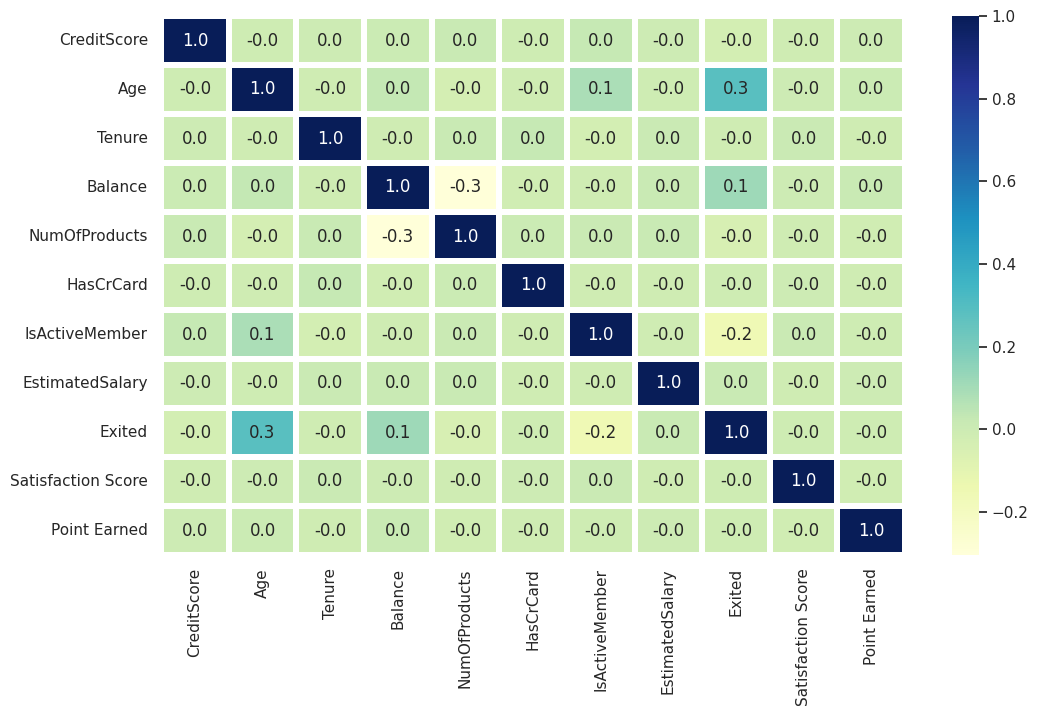

In [ ]:
# Correlação entre as variáveis
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(),annot=True, linewidths=3,cmap='YlGnBu',fmt=".1f")

In [ ]:
# Dropando a variável 'Complain', motivo de a altíssima correlação com a variável target.
df=df.drop(['Complain'],axis=1)

In [ ]:
# Divisão dos dados em X e Y
X=df.drop(['Exited'],axis=1)
y=df['Exited']

# Divisão em dados de treino e de teste
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

Foi utilizado o parâmetro 'stratify=y' para que se garanta que haja estratificação da variável alvo
<br><br>

In [ ]:
# Conferindo a estratificação
print(f'Percentual igual a "0" nos dados de treino: {y_train.value_counts(1)[0]}\n')
print(f'Percentual igual a "0" nos dados de teste: {y_test.value_counts(1)[0]}')

Percentual igual a "0" nos dados de treino: 0.79625

Percentual igual a "0" nos dados de teste: 0.796


In [ ]:
# Transformando as variáveis categóricas em numéricas (após o split)

# Quantidade de classes de cada variável categórica
# Gender: 2 classes - ok
# Geography: 3 classes - ok
# Card Type: 4 classes - ok, no limite para OneHotEncoder

# Instanciando o encoder
encoder = OneHotEncoder()

# Colunas a serem convertidas
columns_enc = ['Gender', 'Geography', 'Card Type']

# Aplicar o OneHotEncoder em X_train
X_train_encoded = encoder.fit_transform(X_train[columns_enc]) #fit_transform
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(columns_enc))

# Aplicar o OneHotEncoder em X_test
X_test_encoded = encoder.transform(X_test[columns_enc]) #somente 'transform'
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(columns_enc))

# Concatenar as colunas codificadas de volta aos dados de treino originais
X_train=X_train.reset_index()
X_train = pd.concat([X_train.drop(columns=columns_enc), X_train_encoded_df], axis=1)
X_train=X_train.drop('index',axis=1)

# Concatenar as colunas codificadas de volta aos dados de teste originais
X_test=X_test.reset_index()
X_test = pd.concat([X_test.drop(columns=columns_enc), X_test_encoded_df], axis=1)
X_test=X_test.drop('index',axis=1)

# Nota: antes de concatenar o dataframe de X_train e X_encoded é necessário resetar o Index de X_train,
# pois como os valores deste são definidos aleatoriamente no split, e os valores dos index do X_encoded são resetados,
# os index não vão casar entre os dataframes, sendo que os valores comuns de index serão concatenados erroneamente, e os valores não
# existentes no index serão adicionados, criando várias novas instâncias e gerando valores 'NaN'

<Axes: >

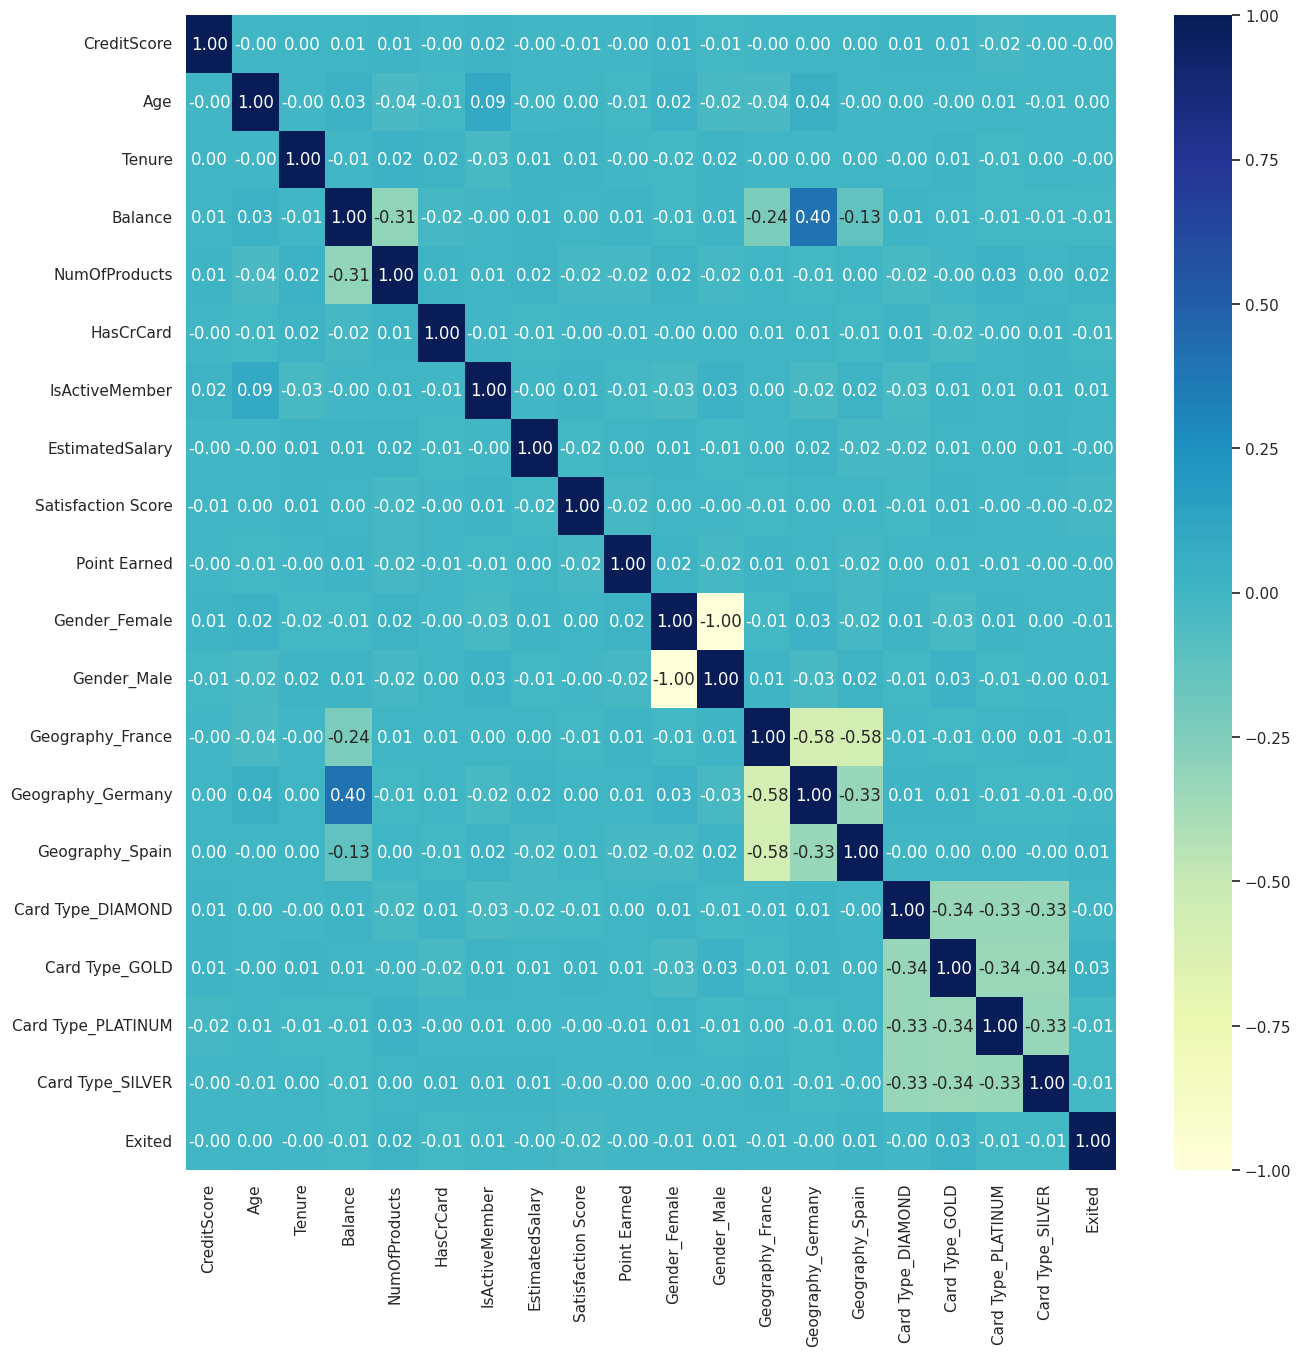

In [ ]:
# Correlação entre as variáveis após a conversão das variáveis numéricas

df_aux=X_train.join(y_train)
plt.figure(figsize=(15, 15))
sns.heatmap(df_aux.corr(),annot=True, cmap='YlGnBu',fmt=".2f")

In [ ]:
# Balanceamento dos dados - somente em dados de treino - garantia de não ocorrência de Dataleakage

# Oversampling através do método SMOTE
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)

#Undersampling através do método NearMiss
from imblearn.under_sampling import NearMiss
nmiss=NearMiss(sampling_strategy='majority') #Reamostrar apenas a classe majoritária

# Dados de treino com oversampling
X_train_os,y_train_os=smote.fit_resample(X_train,y_train)

# Dados de treino com undersampling
X_train_us,y_train_us=nmiss.fit_resample(X_train,y_train)

# Verificando o balanceamento
print(f'''Dados oversampling:
{y_train_os.value_counts()}

Dados undersampling:
{y_train_us.value_counts()}

Dados não balanceados:
{y_train.value_counts()}''')

Dados oversampling:
0    6370
1    6370
Name: Exited, dtype: int64

Dados undersampling:
0    1630
1    1630
Name: Exited, dtype: int64

Dados não balanceados:
0    6370
1    1630
Name: Exited, dtype: int64


In [ ]:
# Padronização dos dados de treino e teste - após o split

# Instanciando
std_scaler=StandardScaler()

# Treino e transformação dos dados de treino e de teste
X_train_std=std_scaler.fit_transform(X_train)   #fit_transform
X_test_std=std_scaler.transform(X_test)         #Somente 'transform'


# Padronização dos dados de treino e teste balanceados

# Treino e transformação oversampling
X_train_os_std=std_scaler.fit_transform(X_train_os) #fit_transform

# Treino e transformação undersampling
X_train_us_std=std_scaler.fit_transform(X_train_us) #fit_transform

#4) Máquina preditiva

##4.1) Regressão Logística

###4.1.1) Modelo baseline com dados desbalanceados

In [ ]:
# Modelo

# Instanciando o modelo
lr_base=LogisticRegression()

# Fazendo o treinamento de modelos baseline - dados padronizados
lr_base.fit(X_train_std,y_train)

# Fazendo as predições do modelo baseline - dados padronizados
y_pred_base=lr_base.predict(X_test_std)

# Extraindo as métricas de modelos baseline
metrics_base_lr={'Acurácia':accuracy_score(y_pred_base,y_test),
            'Precisão':precision_score(y_pred_base,y_test),
            'Recall':recall_score(y_pred_base,y_test),
            'f1 score':f1_score(y_pred_base,y_test)}


# Criando um dataframe com a exibição dos resultados
qd_metrics_base_lr=pd.DataFrame({'Baseline desbal.':pd.Series(metrics_base_lr)})
qd_metrics_base_lr

,Baseline desbal.
Acurácia,0.813000
Precisão,0.210784
Recall,0.623188
f1 score,0.315018


In [ ]:
# Verificando a matriz de confusão
confusion_matrix(y_pred_base,y_test)

array([[1540,  322],
       [  52,   86]])

###4.1.2) Modelo baseline com dados balanceados

In [ ]:
# Modelo oversampling

# Instanciando os modelos
lr_base_os=LogisticRegression()

# Fazendo o treinamento do modelo em dados com oversamplin
lr_base_os.fit(X_train_os_std,y_train_os)

# Fazendo as predições do modelo em dados com oversampling e undersampling
y_pred_base_os   =  lr_base_os.predict(X_test_std)

# Extraindo as métricas com dados oversampling
metrics_base_os_lr={'Acurácia':accuracy_score(y_pred_base_os,y_test),
                  'Precisão':precision_score(y_pred_base_os,y_test),
                  'Recall':recall_score(y_pred_base_os,y_test),
                  'f1 score':f1_score(y_pred_base_os,y_test)}

# Criando um dataframe com a exibição dos resultados
qd_metrics_base_os_lr=pd.DataFrame({'Oversampling':pd.Series(metrics_base_os_lr)})
qd_metrics_base_os_lr

,Oversampling
Acurácia,0.618500
Precisão,0.776961
Recall,0.320526
f1 score,0.453830


In [ ]:
# Verificando a matriz de confusão com os dados em oversampling
confusion_matrix(y_pred_base_os,y_test)

array([[920,  91],
       [672, 317]])

In [ ]:
# Modelo undersampling

# Instanciando os modelos
lr_base_us=LogisticRegression()

# Fazendo o treinamento do modelo em dados com undersampling
lr_base_us.fit(X_train_us_std,y_train_us)

# Fazendo as predições do modelo em dados com undersampling
y_pred_base_us   =  lr_base_us.predict(X_test_std)

# Extraindo as métricas com dados undersampling
metrics_base_us_lr={'Acurácia':accuracy_score(y_pred_base_us,y_test),
                  'Precisão':precision_score(y_pred_base_us,y_test),
                  'Recall':recall_score(y_pred_base_us,y_test),
                  'f1 score':f1_score(y_pred_base_us,y_test)}

# Criando um dataframe com a exibição dos resultados
qd_metrics_base_us_lr=pd.DataFrame({'Undersampling':pd.Series(metrics_base_us_lr)})
qd_metrics_base_us_lr

,Undersampling
Acurácia,0.464500
Precisão,0.720588
Recall,0.235012
f1 score,0.354430


In [ ]:
# Verificando a matriz de confusão com os dados em oversampling
confusion_matrix(y_pred_base_us,y_test)

array([[635, 114],
       [957, 294]])

O balanceamento dos dados não foi eficaz para o modelo de Regressão Logistica.

Assim, o modelo final será treinado com os dados desbalanceados.
<br><br>

###4.1.3) Modelo final com ajuste de hiperparâmetros

In [ ]:
# Criando o modelo
lr=LogisticRegression()

# Grid de hiperparâmetros
range_c=[0.01,0.5,1]
range_max_iter=[70,100,200]
range_solver=['sag','lbfgs']
range_penalty=['l1','l2','elasticnet']
range_class_weight=['balanced',None]

grid_lr={
        'C':[0.01,0.5,1],
        'max_iter':[70,100,200],
        'solver':['sag','lbfgs'],
        'penalty':['l1','l2','elasticnet'],
        'class_weight':['balanced',None]
        }

lr_opt=GridSearchCV(lr,grid_lr,cv=10)

# Treinamento do modelo
lr_opt.fit(X_train_std,y_train)

# Verificação do modelo em dados de teste
y_pred_opt=lr_opt.predict(X_test_std)

# Extraindo as métricas de modelos baseline
metrics_opt_lr={
            'Acurácia':accuracy_score(y_pred_opt,y_test),
            'Precisão':precision_score(y_pred_opt,y_test),
            'Recall':recall_score(y_pred_opt,y_test),
            'f1 score':f1_score(y_pred_opt,y_test)
            }


# Nota: o método recall_score(y_pred, y_test), por default, vai retornar as métricas
# da classe positiva, ou seja, classe representada por 1 (que é o nosso interesse).
# Para exibir outras formas de recall, como recall médio entre as classes, etc,
# utilizar: recall_score(y_pred, y_test, average='macro / micro / binary / False ou None')
# Deault: False ou  None

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: S

In [ ]:
# Criando um dataframe com a exibição dos resultados
qd_metrics_opt_lr=pd.DataFrame({'Reg. Log. Tunado':pd.Series(metrics_opt_lr)})
qd_metrics_opt_lr

,Reg. Log. Tunado
Acurácia,0.814500
Precisão,0.183824
Recall,0.663717
f1 score,0.287908


In [ ]:
# Extração dos melhores hiperparâmetros
best_lr=lr_opt.best_params_
best_lr

{'C': 0.01,
 'class_weight': None,
 'max_iter': 70,
 'penalty': 'l2',
 'solver': 'sag'}

* C = 0.01: valor próximo a zero indica que o melhor modelo é aquele com  maior grau de regularização, visto que C é o inverso da força de regularização.
*class_weight = None: sem utilização de pesos diferentes para as classes minoritarias.
* penalty = 'l2': regularização de Ridge
* solver = 'sag': otimização da função de custo com a utilização do Gradiente Descendente Estocástico.
<br><br>

In [ ]:
# Visualizando a matriz de confusão do modelo
confusion_matrix(y_pred_opt,y_test)

array([[1554,  333],
       [  38,   75]])

##4.2) Random Forest | XGBoost

In [ ]:
# Modelos baseline

# Instanciando
rf=RandomForestClassifier()
xgb=XGBClassifier()

list_model=[rf,xgb]
metrics={'Acurácia':[],'Precisão':[],'Recall':[],'f1 score':[]}

for model in list_model:
  model.fit(X_train,y_train)      #dados sem padronização
  y_pred=model.predict(X_test)
  metrics['Acurácia'].append(accuracy_score(y_pred,y_test))
  metrics['Precisão'].append(precision_score(y_pred,y_test))
  metrics['Recall'].append(recall_score(y_pred,y_test))
  metrics['f1 score'].append(f1_score(y_pred,y_test))

# Criando um dataframe com a exibição dos resultados
qd_metrics=pd.DataFrame(metrics)
qd_metrics.insert(0,'Modelo baseline',['RandomForest','XGBoost'])
qd_metrics


,Modelo baseline,Acurácia,Precisão,Recall,f1 score
0,RandomForest,0.8695,0.473039,0.807531,0.596600
1,XGBoost,0.8540,0.500000,0.698630,0.582857


Os modelos mais complexos apresentaram melhorias consideráveis no Recall.

Ainda assim estes modelos serão submetidos ao GridSearchCV para extração dos melhores hiperparâmetros.
<br><br>

In [ ]:
# Tunagem do modelo Random Forest
rf=RandomForestClassifier()

grid_rf = {
            'n_estimators': [100, 500, 1000],
            'max_depth': [None, 5, 10],
            'class_weight': [None, 'balanced']
          }

# Treinando o modelo na validação cruzada
rf_opt = GridSearchCV(estimator=rf, param_grid=grid_rf, cv=10)
rf_opt.fit(X_train, y_train)        #dados sem padronização
y_pred_opt_rf=rf_opt.predict(X_test)

# Extraindo as métricas de modelos baseline
metrics_opt_rf={
            'Acurácia':accuracy_score(y_pred_opt_rf,y_test),
            'Precisão':precision_score(y_pred_opt_rf,y_test),
            'Recall':recall_score(y_pred_opt_rf,y_test),
            'f1 score':f1_score(y_pred_opt_rf,y_test)
            }

# Criando um dataframe com a exibição dos resultados
qd_metrics_opt_rf=pd.DataFrame({'Random Forest tunado':pd.Series(metrics_opt_rf)})
qd_metrics_opt_rf

# Nota: o método recall_score(y_pred, y_test), por default, vai retornar as métricas
# da classe positiva, ou seja, classe representada por 1 (que é o nosso interesse).
# Para exibir outras formas de recall, como recall médio entre as classes, etc,
# utilizar: recall_score(y_pred, y_test, average='macro / micro / binary / False ou None')
# Deault: False ou  None

,Random Forest tunado
Acurácia,0.871000
Precisão,0.482843
Recall,0.807377
f1 score,0.604294


Houve ligeira melhora na Precisão e Recall.
<br><br>


In [ ]:
# Extração dos melhores hiperparâmetros
best_rf=rf_opt.best_params_
best_rf

{'class_weight': None, 'max_depth': None, 'n_estimators': 1000}

In [ ]:
# Visualizando a matriz de confusão do modelo
confusion_matrix(y_pred_opt_rf,y_test)

array([[1545,  211],
       [  47,  197]])

In [ ]:
# Tunagem do modelo XGBoost
xgb=XGBClassifier()

grid_xgb = {
            'learning_rate': [0.1, 0.01,0.001],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 500, 1000]
}

# Realizar a busca em grade (grid search) para encontrar a melhor combinação de hiperparâmetros
xgb_opt = GridSearchCV(estimator=xgb, param_grid=grid_xgb, cv=10)
xgb_opt.fit(X_train, y_train)     #dados sem padronização
y_pred_opt_xgb=xgb_opt.predict(X_test)

# Extraindo as métricas de modelos baseline
metrics_opt_xgb={
            'Acurácia':accuracy_score(y_pred_opt_xgb,y_test),
            'Precisão':precision_score(y_pred_opt_xgb,y_test),
            'Recall':recall_score(y_pred_opt_xgb,y_test),
            'f1 score':f1_score(y_pred_opt_xgb,y_test)
            }

# Criando um dataframe com a exibição dos resultados
qd_metrics_opt_xgb=pd.DataFrame({'XGB tunado':pd.Series(metrics_opt_xgb)})
qd_metrics_opt_xgb

# Nota: o método recall_score(y_pred, y_test), por default, vai retornar as métricas
# da classe positiva, ou seja, classe representada por 1 (que é o nosso interesse).
# Para exibir outras formas de recall, como recall médio entre as classes, etc,
# utilizar: recall_score(y_pred, y_test, average='macro / micro / binary / False ou None')
# Deault: False ou  None

,XGB tunado
Acurácia,0.865000
Precisão,0.465686
Recall,0.785124
f1 score,0.584615


Houve melhora considerável na métrica Recall.
<br><br>

In [ ]:
# Extração dos melhores hiperparâmetros
best_xgb=xgb_opt.best_params_
best_xgb

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

In [ ]:
# Visualizando a matriz de confusão do modelo
confusion_matrix(y_pred_opt_xgb,y_test)

array([[1540,  218],
       [  52,  190]])

#5) Conclusões

In [ ]:
# Quadro de desempenho geral

qd_geral=pd.DataFrame()
qd_geral=qd_metrics_opt_lr.join([qd_metrics_opt_rf,qd_metrics_opt_xgb])
qd_geral.rename(columns={'Reg. Log. Tunado':'RegLog','Random Forest tunado':'RandFor','XGB tunado':'XGB'},inplace=True)
qd_geral.apply(lambda x: round(100*x,1))

,RegLog,RandFor,XGB
Acurácia,81.4,87.1,86.5
Precisão,18.4,48.3,46.6
Recall,66.4,80.7,78.5
f1 score,28.8,60.4,58.5


Dentre os modelos analisados, o algoritmo Random Forest foi o que apresentou o melhor desempenho na métrica Recall, sendo assim, será o modelo disponibilizado para produção.
<br><br>
Com o modelo é possível prever e agir na retenção de 80% das pessoas que desejam deixar o banco!
<br><br>
Acredita-se que, com FeatureEngineering é possível melhorar um pouco mais as métricas do modelo.
<br><br>
Vale ressaltar que o tempo de treinamento de cada modelo tunado foi de aproximadamente:
* 40s para Regressão Linear
* 16min para Random Forest
* 26min para XGBoost.
<br><br>